In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
import sys

# Gereksiz uyarıları bastır


In [49]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Görsel ve tablo ayarları


In [50]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

In [51]:
df = pd.read_csv('datasets/BankChurners.csv')

df.head()            # İlk 5 satır
df.shape             # Satır ve sütun sayısı
df.info()            # Değişken tipleri
df.describe().T      # Sayısal değişkenlerin istatistikleri
df.isnull().sum()    # Eksik değer kontrolü

# "Unknown" olan değerleri temizle
df = df[df != 'Unknown'].dropna()

# Gereksiz sütunları kaldır
df.drop([
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [52]:
# CLIENTNUM sütununu kaldır (id bilgisi olduğu için)
df.set_index('CLIENTNUM', inplace=True)
df.reset_index(inplace=True)
df.drop('CLIENTNUM', axis=1, inplace=True)

Değişken Türlerinin Belirlenmesi

In [53]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, nümerik ve kardinal değişkenleri otomatik olarak tespit eder.
    """
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtype) in ['object', 'category', 'bool']]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtype in ['float', 'int'] and dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in cat_cols if dataframe[col].nunique() > car_th and str(dataframe[col].dtype) in ['object', 'category']]

    cat_cols = num_but_cat + cat_cols
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype in ['float', 'int']]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observation: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car, num_but_cat

grab_col_names(df, cat_th=10, car_th=20)


Observation: 7081
Variables: 20
cat_cols: 10
num_cols: 10
cat_but_car: 0
num_but_cat: 4


(['Dependent_count',
  'Total_Relationship_Count',
  'Months_Inactive_12_mon',
  'Contacts_Count_12_mon',
  'Attrition_Flag',
  'Gender',
  'Education_Level',
  'Marital_Status',
  'Income_Category',
  'Card_Category'],
 ['Customer_Age',
  'Months_on_book',
  'Credit_Limit',
  'Total_Revolving_Bal',
  'Avg_Open_To_Buy',
  'Total_Amt_Chng_Q4_Q1',
  'Total_Trans_Amt',
  'Total_Trans_Ct',
  'Total_Ct_Chng_Q4_Q1',
  'Avg_Utilization_Ratio'],
 [],
 ['Dependent_count',
  'Total_Relationship_Count',
  'Months_Inactive_12_mon',
  'Contacts_Count_12_mon'])

In [54]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df, cat_th=10, car_th=20)

Observation: 7081
Variables: 20
cat_cols: 10
num_cols: 10
cat_but_car: 0
num_but_cat: 4


Kategorik ve Sayısal Özet Fonksiyonları

In [55]:
def cat_summary(dataframe, col_name, plot=False):
    """Kategorik değişkenler için değer sayısı ve oranları"""
    print(pd.DataFrame({
        col_name: dataframe[col_name].value_counts(),
        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)
    }))
    print('###########################################')
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title(col_name.upper() + ' Grafiği')
        plt.show(block=True)

def num_summary(dataframe, numarical_cols, plot=False):
    """Sayısal değişkenler için özet istatistikler"""
    quantiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    print(dataframe[numarical_cols].quantile(quantiles))
    if plot:
        dataframe[numarical_cols].hist()
        plt.title(numarical_cols.upper() + ' Histogram')
        plt.xlabel(numarical_cols.upper())
        plt.show()

                 Dependent_count      Ratio
Dependent_count                            
3                           1929  27.241915
2                           1880  26.549922
1                           1274  17.991809
4                           1077  15.209716
0                            636   8.981782
5                            285   4.024855
###########################################


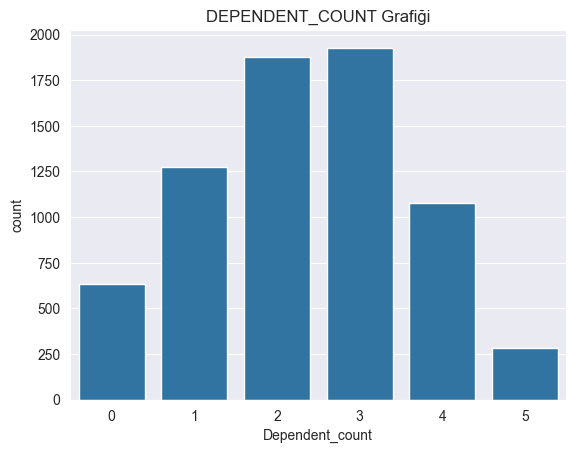

                          Total_Relationship_Count      Ratio
Total_Relationship_Count                                     
3                                             1617  22.835758
5                                             1363  19.248694
4                                             1350  19.065104
6                                             1276  18.020054
2                                              848  11.975710
1                                              627   8.854682
###########################################


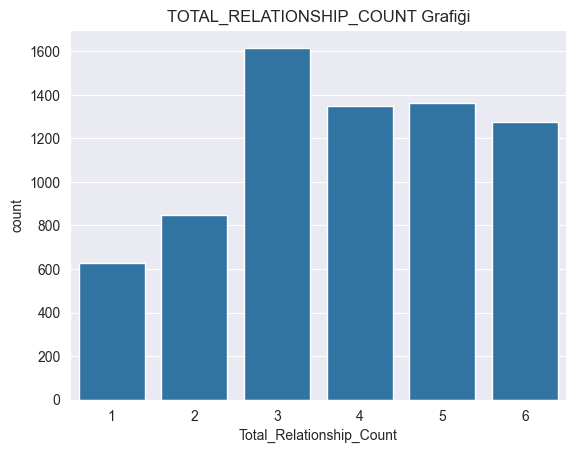

                        Months_Inactive_12_mon      Ratio
Months_Inactive_12_mon                                   
3                                         2724  38.469143
2                                         2320  32.763734
1                                         1525  21.536506
4                                          289   4.081344
5                                          129   1.821777
6                                           75   1.059172
0                                           19   0.268324
###########################################


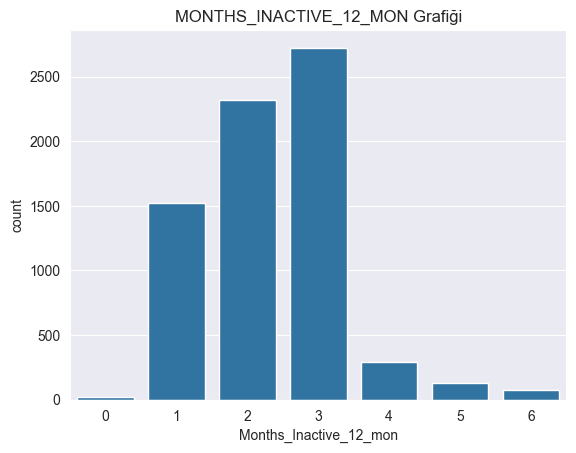

                       Contacts_Count_12_mon      Ratio
Contacts_Count_12_mon                                  
3                                       2354  33.243892
2                                       2271  32.071741
1                                       1029  14.531846
4                                        978  13.811609
0                                        288   4.067222
5                                        131   1.850021
6                                         30   0.423669
###########################################


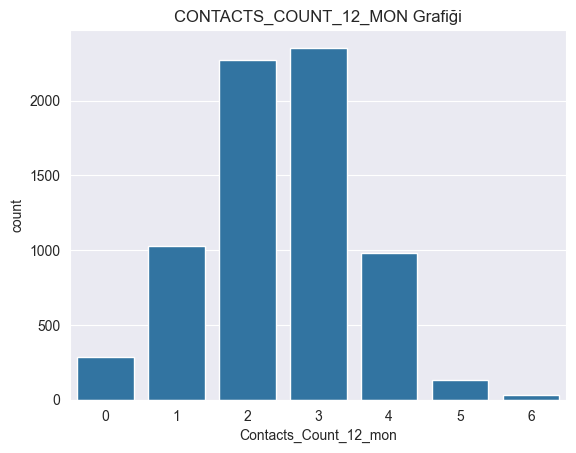

                   Attrition_Flag      Ratio
Attrition_Flag                              
Existing Customer            5968  84.281881
Attrited Customer            1113  15.718119
###########################################


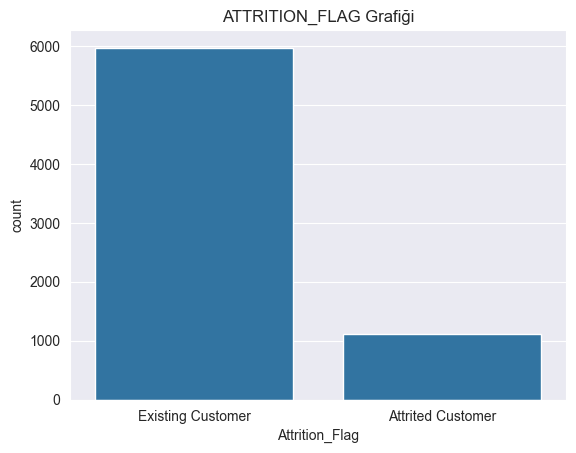

        Gender      Ratio
Gender                   
M         3706  52.337241
F         3375  47.662759
###########################################


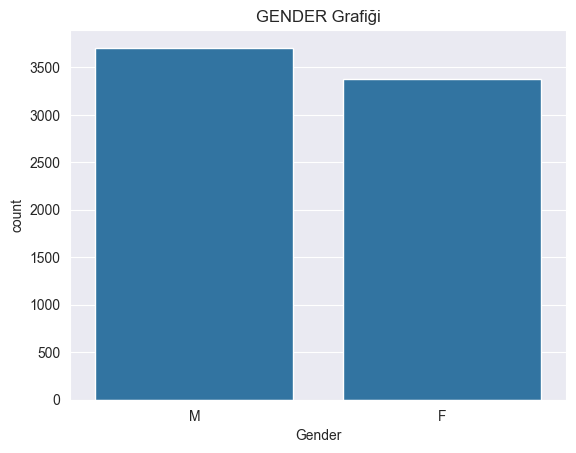

                 Education_Level      Ratio
Education_Level                            
Graduate                    2591  36.590877
High School                 1653  23.344160
Uneducated                  1204  17.003248
College                      844  11.919220
Post-Graduate                431   6.086711
Doctorate                    358   5.055783
###########################################


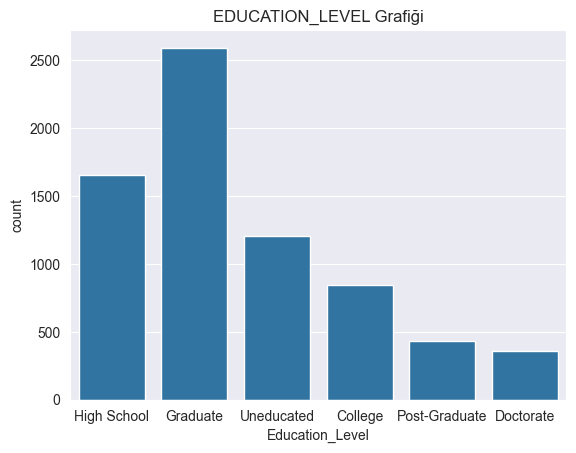

                Marital_Status      Ratio
Marital_Status                           
Married                   3564  50.331874
Single                    2948  41.632538
Divorced                   569   8.035588
###########################################


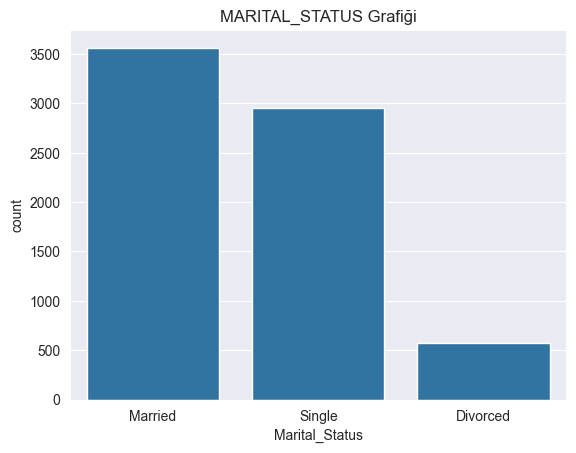

                 Income_Category      Ratio
Income_Category                            
Less than $40K              2792  39.429459
$40K - $60K                 1412  19.940686
$80K - $120K                1202  16.975004
$60K - $80K                 1103  15.576896
$120K +                      572   8.077955
###########################################


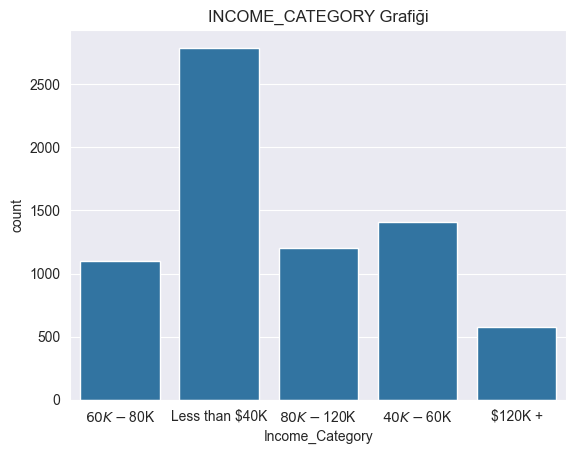

               Card_Category      Ratio
Card_Category                          
Blue                    6598  93.178930
Silver                   391   5.521819
Gold                      81   1.143906
Platinum                  11   0.155345
###########################################


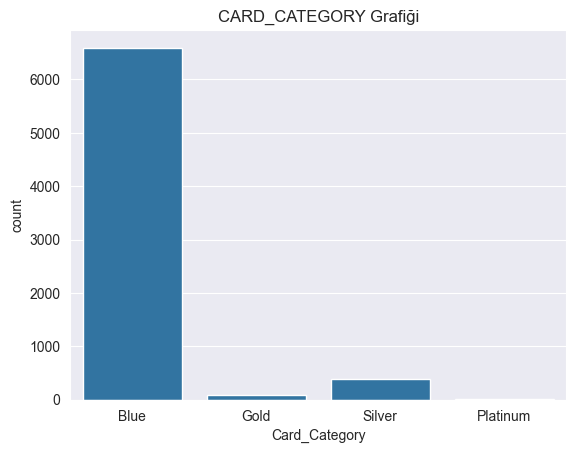

In [56]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

0.05    33.0
0.10    36.0
0.20    39.0
0.30    42.0
0.40    44.0
0.50    46.0
0.60    49.0
0.70    51.0
0.80    53.0
0.90    57.0
0.95    60.0
0.99    64.2
Name: Customer_Age, dtype: float64


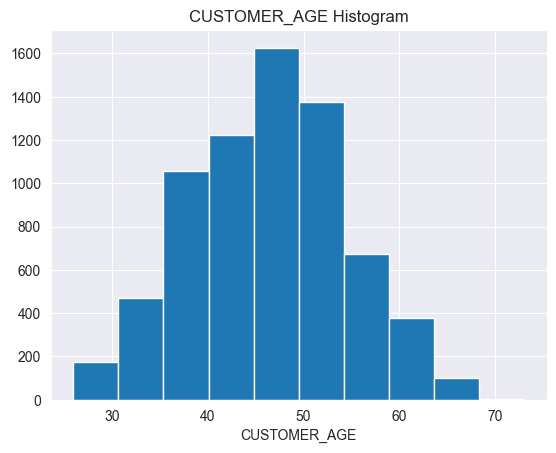

0.05    22.0
0.10    26.0
0.20    30.0
0.30    33.0
0.40    36.0
0.50    36.0
0.60    36.0
0.70    39.0
0.80    42.0
0.90    47.0
0.95    50.0
0.99    56.0
Name: Months_on_book, dtype: float64


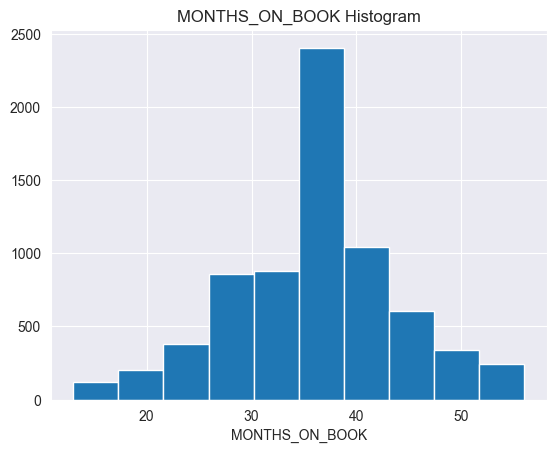

0.05     1438.3
0.10     1717.0
0.20     2255.0
0.30     2721.0
0.40     3290.0
0.50     4287.0
0.60     6043.0
0.70     8760.0
0.80    13356.0
0.90    23250.0
0.95    34516.0
0.99    34516.0
Name: Credit_Limit, dtype: float64


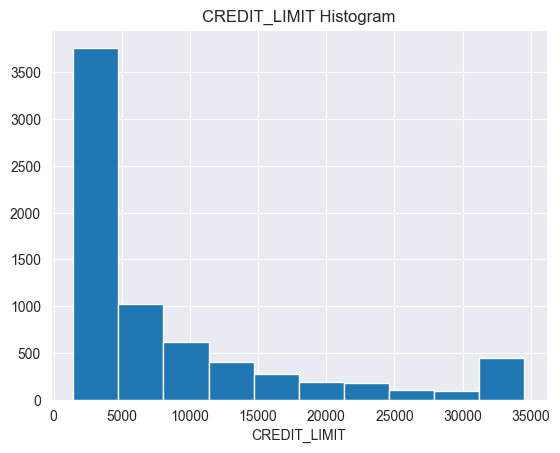

0.05       0.0
0.10       0.0
0.20       0.0
0.30     757.0
0.40    1046.0
0.50    1282.0
0.60    1484.0
0.70    1673.0
0.80    1903.0
0.90    2231.0
0.95    2517.0
0.99    2517.0
Name: Total_Revolving_Bal, dtype: float64


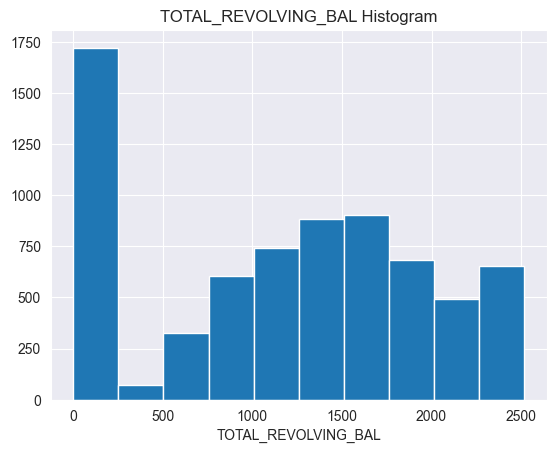

0.05      462.0
0.10      658.3
0.20      991.0
0.30     1438.3
0.40     2043.0
0.50     3250.0
0.60     4871.0
0.70     7577.0
0.80    12177.0
0.90    21901.0
0.95    32339.0
0.99    34516.0
Name: Avg_Open_To_Buy, dtype: float64


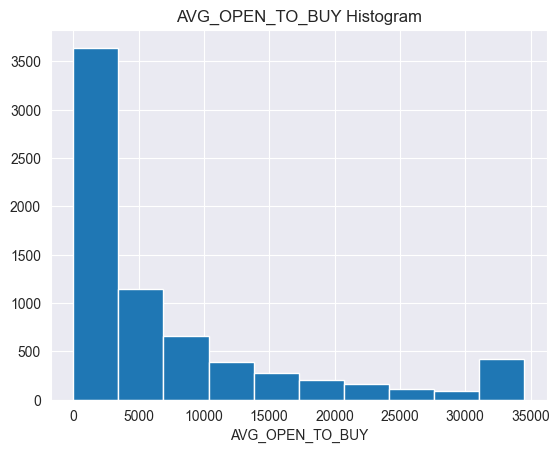

0.05    0.4630
0.10    0.5310
0.20    0.6030
0.30    0.6540
0.40    0.6960
0.50    0.7350
0.60    0.7790
0.70    0.8280
0.80    0.8920
0.90    1.0030
0.95    1.1140
0.99    1.5442
Name: Total_Amt_Chng_Q4_Q1, dtype: float64


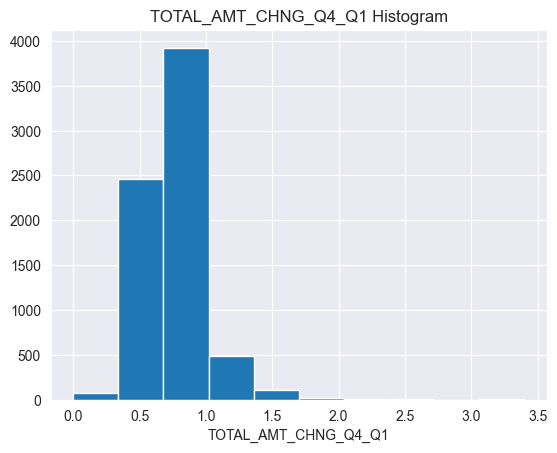

0.05     1260.0
0.10     1468.0
0.20     1865.0
0.30     2328.0
0.40     3030.0
0.50     3831.0
0.60     4240.0
0.70     4564.0
0.80     4926.0
0.90     8293.0
0.95    14279.0
0.99    16003.0
Name: Total_Trans_Amt, dtype: float64


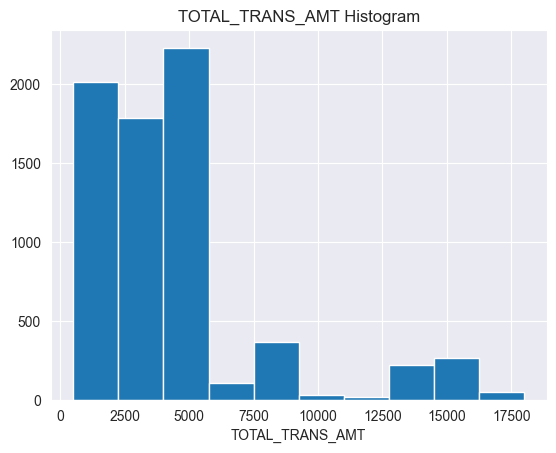

0.05     27.0
0.10     33.0
0.20     40.0
0.30     49.0
0.40     60.0
0.50     67.0
0.60     72.0
0.70     78.0
0.80     83.0
0.90     93.0
0.95    106.0
0.99    123.0
Name: Total_Trans_Ct, dtype: float64


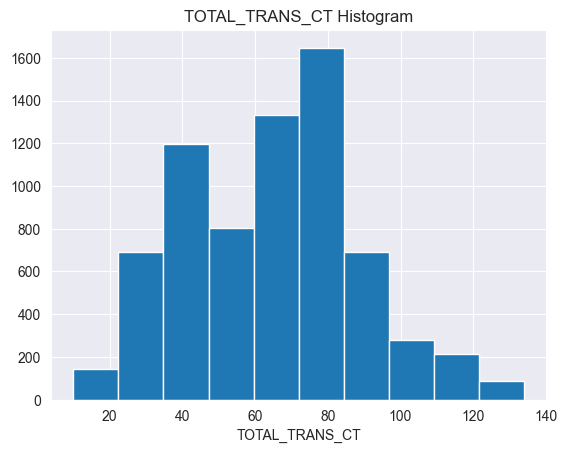

0.05    0.368
0.10    0.452
0.20    0.545
0.30    0.609
0.40    0.657
0.50    0.700
0.60    0.745
0.70    0.791
0.80    0.853
0.90    0.947
0.95    1.062
0.99    1.444
Name: Total_Ct_Chng_Q4_Q1, dtype: float64


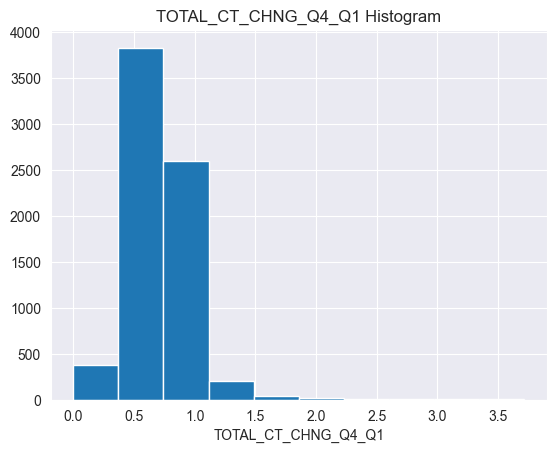

0.05    0.0000
0.10    0.0000
0.20    0.0000
0.30    0.0530
0.40    0.1050
0.50    0.1860
0.60    0.2960
0.70    0.4490
0.80    0.5840
0.90    0.7150
0.95    0.7970
0.99    0.9122
Name: Avg_Utilization_Ratio, dtype: float64


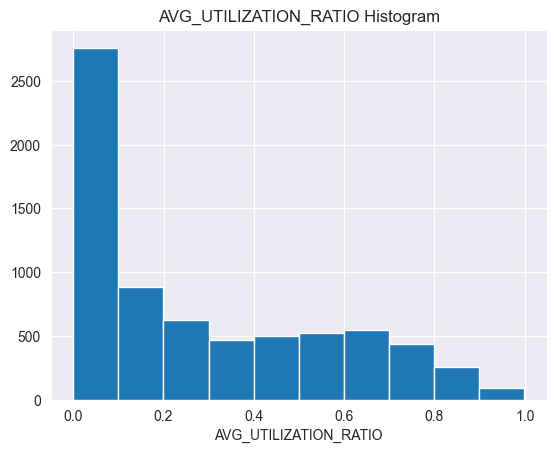

In [57]:
# Tüm sayısal değişkenleri özetle
for col in num_cols:
    num_summary(df, col, plot=True)

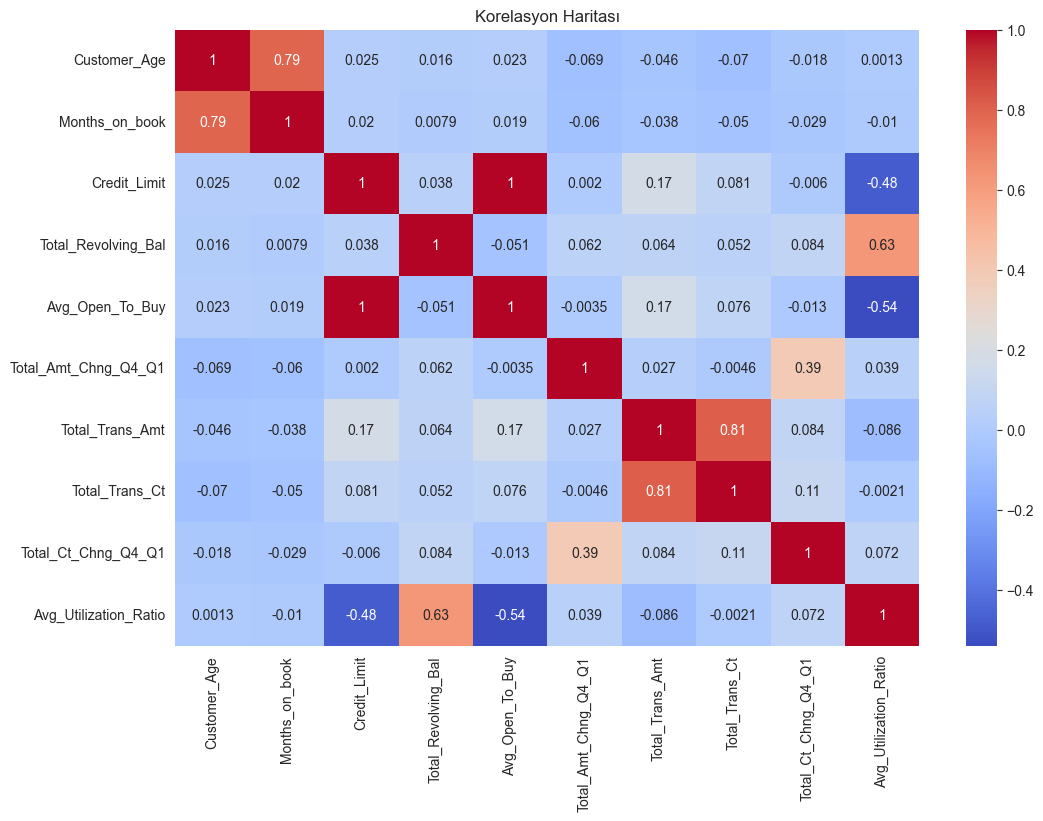

In [58]:
# Korelasyon ısı haritası
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasyon Haritası")
plt.show()

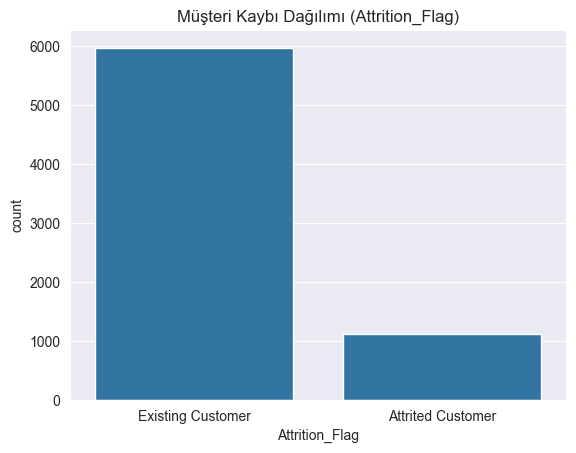

In [59]:
# 4️⃣ Hedef Değişken (Attrition_Flag) Analizi
# ====================================
df['Attrition_Flag'].value_counts()
sns.countplot(x='Attrition_Flag', data=df)
plt.title("Müşteri Kaybı Dağılımı (Attrition_Flag)")
plt.show()

In [60]:
# Kategorik değişkenlerin hedefle ilişkisi
for col in cat_cols:
    print(f"{col} vs Attrition_Flag")
    print(pd.crosstab(df[col], df['Attrition_Flag'], normalize='index') * 100)
    print("##########################################")

Dependent_count vs Attrition_Flag
Attrition_Flag   Attrited Customer  Existing Customer
Dependent_count                                      
0                        15.880503          84.119497
1                        14.442700          85.557300
2                        15.159574          84.840426
3                        17.055469          82.944531
4                        15.877437          84.122563
5                        15.087719          84.912281
##########################################
Total_Relationship_Count vs Attrition_Flag
Attrition_Flag            Attrited Customer  Existing Customer
Total_Relationship_Count                                      
1                                 25.199362          74.800638
2                                 27.830189          72.169811
3                                 17.130489          82.869511
4                                 10.444444          89.555556
5                                 11.738811          88.261189
6      

In [61]:
# Sayısal değişkenlerin hedefe göre ortalamaları
for col in num_cols:
    print(f"{col} ortalamaları:")
    print(df.groupby("Attrition_Flag")[col].mean())
    print("##########################################")

Customer_Age ortalamaları:
Attrition_Flag
Attrited Customer    46.510332
Existing Customer    46.317359
Name: Customer_Age, dtype: float64
##########################################
Months_on_book ortalamaları:
Attrition_Flag
Attrited Customer    36.152740
Existing Customer    35.949397
Name: Months_on_book, dtype: float64
##########################################
Credit_Limit ortalamaları:
Attrition_Flag
Attrited Customer    8158.579964
Existing Customer    8555.099196
Name: Credit_Limit, dtype: float64
##########################################
Total_Revolving_Bal ortalamaları:
Attrition_Flag
Attrited Customer     668.353998
Existing Customer    1260.589980
Name: Total_Revolving_Bal, dtype: float64
##########################################
Avg_Open_To_Buy ortalamaları:
Attrition_Flag
Attrited Customer    7490.225966
Existing Customer    7294.509216
Name: Avg_Open_To_Buy, dtype: float64
##########################################
Total_Amt_Chng_Q4_Q1 ortalamaları:
Attrition_Flag
Attr

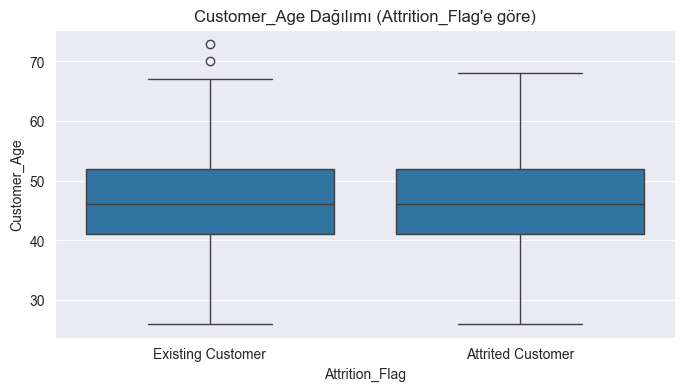

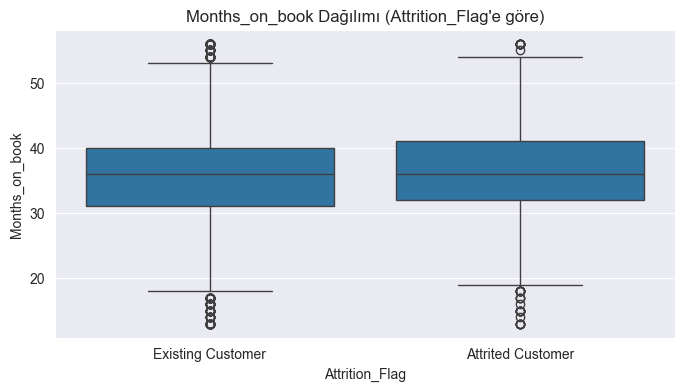

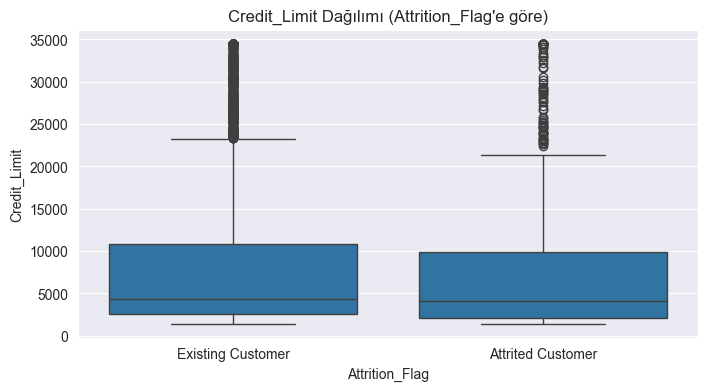

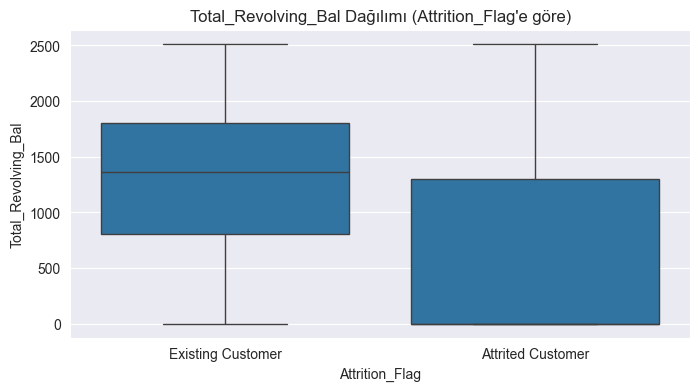

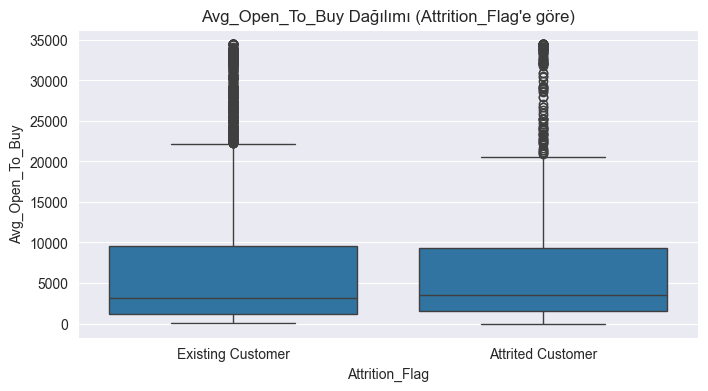

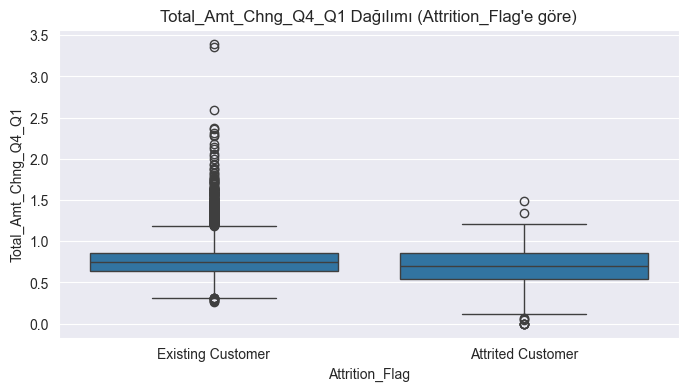

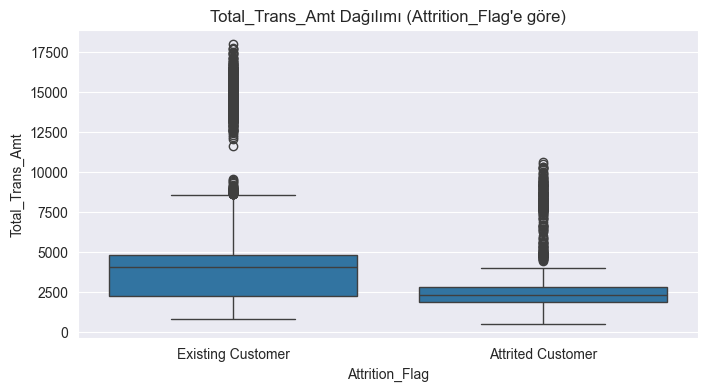

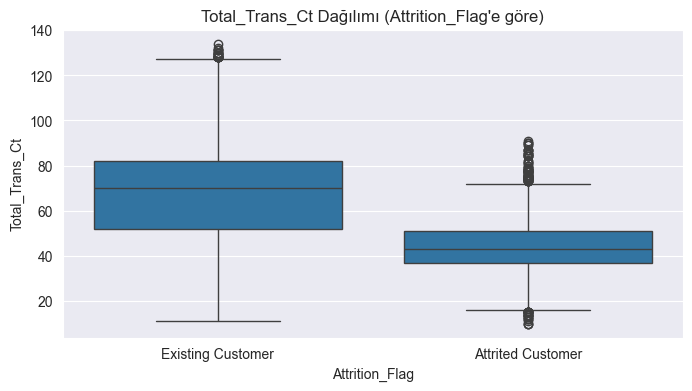

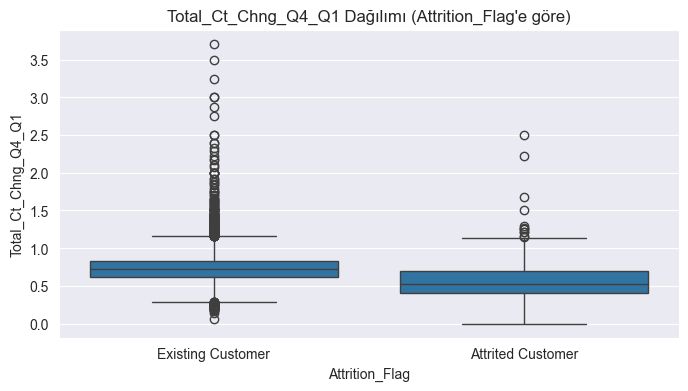

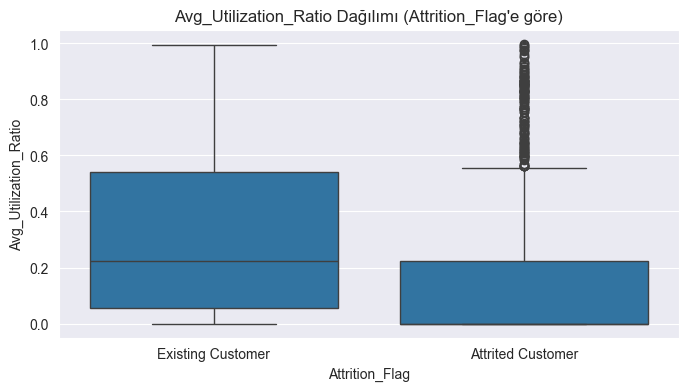

In [62]:
# Sayısal değişkenlerin hedefe göre dağılım grafikleri
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="Attrition_Flag", y=col, data=df)
    plt.title(f"{col} Dağılımı (Attrition_Flag'e göre)")
    plt.show()

In [63]:
# 5️⃣ Aykırı Değer Analizi
# ====================================
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    """Aykırı değer eşiklerini hesapla"""
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * iqr
    up_limit = quartile3 + 1.5 * iqr
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    """Aykırı değer var mı kontrol et"""
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up) | (dataframe[col_name] < low)].any(axis=None):
        return True
    else:
        return False

In [64]:
# Her sayısal değişken için aykırı değer kontrolü
for col in num_cols:
    print(col, ":", check_outlier(df, col))

Customer_Age : False
Months_on_book : False
Credit_Limit : False
Total_Revolving_Bal : False
Avg_Open_To_Buy : False
Total_Amt_Chng_Q4_Q1 : True
Total_Trans_Amt : False
Total_Trans_Ct : False
Total_Ct_Chng_Q4_Q1 : True
Avg_Utilization_Ratio : False


In [65]:
# Hedef değişkeni hariç tut
cat_cols = [col for col in cat_cols if col != 'Attrition_Flag']
cat_cols

['Dependent_count',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [66]:
# Kategorik değişkenleri dummy değişkenlere çevir
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [67]:
# Hedef değişkeni ikili (0-1) hale getir
df['Attrition_Flag'] = np.where(df['Attrition_Flag'] == 'Attrited Customer', 1, 0)
df['Attrition_Flag'].head(3)

0    0
1    0
2    0
Name: Attrition_Flag, dtype: int64

Modelleme - Random Forest


In [68]:
# Bağımlı ve bağımsız değişkenleri ayır
X = df.drop('Attrition_Flag', axis=1)
y = df['Attrition_Flag']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 1, 1], shape=(1417,))

In [72]:
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9477769936485533


In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1205
           1       0.94      0.70      0.80       212

    accuracy                           0.95      1417
   macro avg       0.94      0.84      0.88      1417
weighted avg       0.95      0.95      0.94      1417



In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1205
           1       0.94      0.70      0.80       212

    accuracy                           0.95      1417
   macro avg       0.94      0.84      0.88      1417
weighted avg       0.95      0.95      0.94      1417



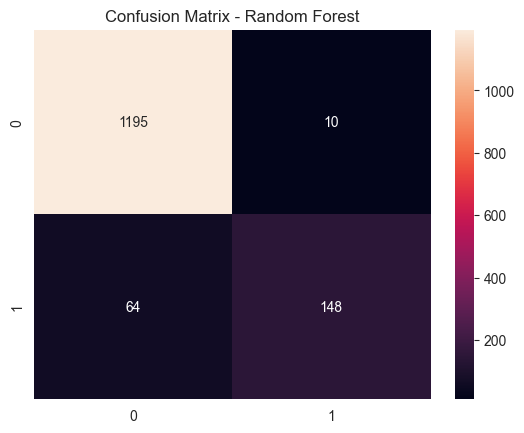

In [75]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

Modelin en etkili gördüğü faktörler genelde:

Total_Trans_Ct → Az işlem yapan müşteriler ayrılıyor.

Total_Trans_Amt → Düşük işlem hacmi = riskli müşteri.

Months_Inactive_12_mon → Uzun süre pasif kalanlar ayrılıyor.

Total_Relationship_Count → Az ürün kullanan müşteriler ayrılıyor.

Credit_Limit → Çok düşük limitli hesaplar riskte.

Pasif, az işlem yapan, düşük gelirli veya düşük limitli müşteriler bankadan ayrılma eğiliminde